In [ ]:
#!pip install numpy
#!pip install matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#For test 2 and test 3, just change the initial conditions.
**Note** : For any questions related to the code please contact [Suliman Badour](https://github.com/sulimanbadour1)

In [ ]:

### TEST 1 ### WITH SMOOTHING and  MINMOD LIMTER
# Constants and initial conditions for Test 1
gamma = 1.4  # Specific heat ratio for ideal gas
M = 100  # Number of cells for spatial discretization
x0 = 0.3  # Position of initial discontinuity for Test 1
x = np.linspace(0, 1, M)  # Spatial domain from 0 to 1
dx = x[1] - x[0]  # Delta x, the distance between cell centers

In [ ]:
# Initial conditions for density (rho), velocity (u), and pressure (p) for Test 2
WL = np.array([1.0, 0.75, 1.0])  # Left state (rho, u, p)
WR = np.array([0.125, 0.0, 0.1])  # Right state (rho, u, p)
U = np.zeros((3, M))  # Array to store the solution


In [ ]:
# Assign initial conditions to the solution array
U[:, : int(M * x0)] = WL.reshape(3, 1)
U[:, int(M * x0) :] = WR.reshape(3, 1)

# Convert initial pressure to total energy for conservative form
U[1, :] *= U[0, :]  # Convert velocity to momentum (rho*u)
U[2, :] = (
    U[2, :] / (gamma - 1) + 0.5 * U[1, :] ** 2 / U[0, :]
)  # Convert pressure to total energy (rho*e)



In [ ]:
def minmod(e, dx):
    sigma = np.zeros_like(e)
    theta = (
        1.0  # A factor that adjusts the aggressiveness of the limiter (1 <= theta <= 2)
    )
    for i in range(1, len(e) - 1):
        delta_e = e[i + 1] - e[i]
        if e[i] > 0:
            sigma[i] = max(
                0, min(theta * delta_e / dx, e[i] / dx, theta * (e[i] - e[i - 1]) / dx)
            )
        else:
            sigma[i] = min(
                0, max(theta * delta_e / dx, e[i] / dx, theta * (e[i] - e[i - 1]) / dx)
            )
    return sigma


In [ ]:

# Define the Steger-Warming FVS scheme function with reconstruction
def steger_warming(U, dx, dt, gamma):
    # Convert conservative variables (U) to primitive variables (rho, u, p, e)
    rho = U[0, :]
    u = U[1, :] / rho
    e = U[2, :] / rho
    p = (gamma - 1) * rho * (e - 0.5 * u**2)

    # Calculate flux for each component of U
    F = np.zeros_like(U)
    F[0, :] = rho * u  # Mass flux rho*u
    F[1, :] = rho * u**2 + p  # Momentum flux rho*u^2 + p
    F[2, :] = (U[2, :] + p) * u  # Energy flux (rho*e + p)*u

    # Reconstruction step using minmod limiter
    U_left = np.zeros_like(U)
    U_right = np.zeros_like(U)
    for i in range(3):
        sigma = minmod(U[i, :], dx)
        U_left[i, 1:-1] = U[i, 1:-1] + sigma[1:-1] * dx / 2
        U_right[i, :-2] = U[i, 1:-1] - sigma[1:-1] * dx / 2

    # Eigenvalues (for the splitting)
    a = np.sqrt(gamma * p / rho)
    lambda_1 = u - a
    lambda_3 = u + a

    # Splitting of fluxes into positive and negative parts
    F_plus = 0.5 * (F + np.abs(lambda_1) * U)
    F_minus = 0.5 * (F - np.abs(lambda_3) * U)

    # Compute numerical flux at interfaces
    num_flux = F_plus[:, :-1] + F_minus[:, 1:]

    # Update the conservative variables in the domain (excluding boundaries)
    U[:, 1:-1] -= (dt / dx) * (num_flux[:, 1:] - num_flux[:, :-1])

    # Apply transmissive boundary conditions
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    return U



In [ ]:
# Setup for time-stepping
t_final = 0.3  # Final time to reach for Test 2
CFL = 0.9  # Courant number for stability

In [ ]:
# Time integration using the Steger-Warming FVS scheme
t = 0
step = 0  # Initialize step counter
while t < t_final:
    # Compute the time step based on the current CFL condition
    u_max = max(
        np.abs(U[1, :] / U[0, :]) + np.sqrt(gamma * (gamma - 1) * U[2, :] / U[0, :])
    )
    dt = CFL * dx / u_max

    # Reduce the time step by a factor of 0.2 for the first five steps
    if step < 5:
        dt *= 0.2

    # Adjust dt to finish exactly at t_final
    if t + dt > t_final:
        dt = t_final - t

    U = steger_warming(U, dx, dt, gamma)
    t += dt
    step += 1  # Increment step counter




In [ ]:
# Extract physical quantities from the conservative variables
rho = U[0, :]  # Density
u = U[1, :] / rho  # Velocity
e = U[2, :] / rho  # Specific internal energy
p = (gamma - 1) * rho * (e - 0.5 * u**2)  # Pressure

In [ ]:
# Plotting the results for density, velocity, pressure, and internal energy
plt.figure(figsize=(12, 10))

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

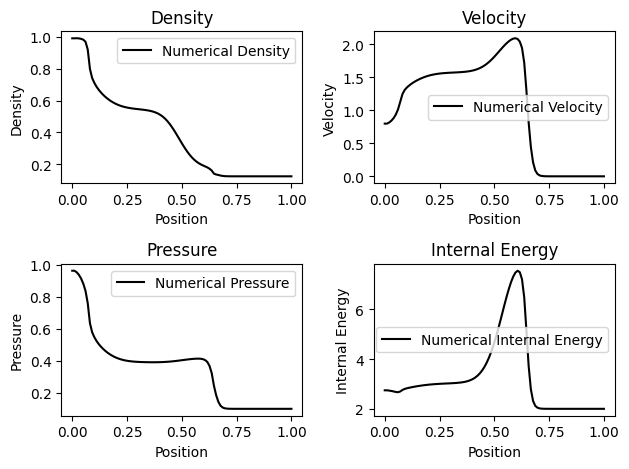

In [ ]:

# Density plot
plt.subplot(2, 2, 1)
plt.plot(x, rho, "k-", label="Numerical Density")
plt.title("Density")
plt.xlabel("Position")
plt.ylabel("Density")
plt.legend()

# Velocity plot
plt.subplot(2, 2, 2)
plt.plot(x, u, "k-", label="Numerical Velocity")
plt.title("Velocity")
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.legend()

# Pressure plot
plt.subplot(2, 2, 3)
plt.plot(x, p, "k-", label="Numerical Pressure")
plt.title("Pressure")
plt.xlabel("Position")
plt.ylabel("Pressure")
plt.legend()

# Internal energy plot
plt.subplot(2, 2, 4)
plt.plot(x, e, "k-", label="Numerical Internal Energy")
plt.title("Internal Energy")
plt.xlabel("Position")
plt.ylabel("Internal Energy")
plt.legend()

plt.tight_layout()
plt.show()
